<a href="https://colab.research.google.com/github/hoopercesar/Preprocesamiento-de-Imagenes-para-IA/blob/main/preprocesamiento_imagenes_para_IA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En este notebook --realizado en Google Colab-- se utilizarán algunas técnicas de preprocesamiento de imágenes para Inteligencia Artificial. Estas técnicas son:
  * Redimensionamiento usando OpenCv
  * Creación de Imágenes sintéticas usando ImageDataGenerator de tensorflow

En esta ocasión se usarán imágenes descargadas de la red, de personajes conocidos, con el solo fin de ejemplificar los métodos a utilizar.


In [1]:
!pip3 install -q -U watermark

In [2]:
# imports basicos
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Imports para manipulación de imágenes
import os
import cv2
import shutil

# Imports para Deep Learning
import tensorflow
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "César S. Hooper" --iversions

Author: César S. Hooper

numpy     : 1.19.5
pandas    : 1.1.5
cv2       : 4.1.2
tensorflow: 2.6.0
keras     : 2.6.0
matplotlib: 3.2.2
IPython   : 5.5.0



In [4]:
# con este se accede a los archivos contenidos en el drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Una vez montado el drive con los directorios, se debe crear el path para acceder al directorio donde se encuentran las imágenes. 

In [5]:
# este es el path para la carpeta que contiene las imágenes en el drive
path = '/content/drive/MyDrive/imagenes/'

In [23]:
os.listdir(path)

['arnold.jpg',
 'silvester.jpg',
 'obama.jpg',
 'einstein.jpg',
 'angelina.jpg',
 'rihanna.jpg',
 'will_smith.jpg',
 'marilyn.jpg',
 'brad.jpg',
 '.ipynb_checkpoints']

In [25]:
# creamos dataframe con el nombre de las imágenes
imagenes = pd.DataFrame(lista_imagenes, columns = ['image_id'])
imagenes

,image_id
0,arnold.jpg
1,silvester.jpg
2,obama.jpg
3,einstein.jpg
4,angelina.jpg
5,rihanna.jpg
6,will_smith.jpg
7,marilyn.jpg
8,brad.jpg
9,.ipynb_checkpoints


### Extracción de metadatos de las imágenes
Los metadatos contienen información sobre la imagen. Número de pixeles, valor de los pixeles, etc. Estos datos son importantes al momento de entrenar una inteligencia artificial.
Vamos a crear una función que extrae los metadatos de las imágenes y que entregará la siguiente información.

 * altura: medida en cantidad de pixeles en la vertical de la imagen.
 * ancho: medido en cantidad de pixeles en la horizontal de la imagen.
 * pix_max, pix_min: el valor máximo y mínimo según código de colores. 
 * número de canales: cantidad de componentes de la imagen. 
 * tamaño: multiplicación de 

\begin{align}
      tamano = (altura)\cdot(ancho)\cdot(canales)
      \end{align}

 

In [31]:
# función para extraer los metadatos de las imágenes
def metadatos(imagen):
    
    """" pix_max, pix_min, alto, ancho, canales, tamano = metadatos(imagen)"""
    
    # extrae valor máximo y minimo de cada pixel para cada imagen
    # según código de color 0=negro, 255=blanco
    # transforamos la imagen en un arreglo

    imag_array = np.array(imagen)
    pix_max = imag_array.max()
    pix_min = imag_array.min()
    
    # extrae alto, ancho y número de canales de cada imagen
    alto = imag_array.shape[0]
    ancho = imag_array.shape[1]
    canales = imag_array.shape[2]
    tamano = alto*ancho*canales
    
    #metadatos = {'max_pix': pix_max, 'min_pix': pix_min, 
    #                   'alto':alto, 'ancho': ancho, 'canales':canales, 'tamano':tamano}
    
    
    return pix_max, pix_min, alto, ancho, canales, tamano

Loop para llenar DataFrame con los metadatos de cada imagen

In [32]:
# Loop para llenar DF con los metadatos de cada imagen
# CREA EL DF
imagens = pd.DataFrame(columns = ['image_id', 'pix_max', 
                                  'pix_min', 'altura', 'ancho', 'canales', 
                                  'tamano'])

# ciclo for para recorrer la lista de imagenes
for foto in lista_imagenes:

  # esta línea se agrega porque dentro de cada directorio google colab guarda
  # una copia de este jupyter notebook .ipynb_checkpoints
  if foto[-1] == 'g':
    # crea  el camino para llegar a la imagen
    # path fue creado en una de las líneas arriba
    camino_foto = path + foto
    # carga la imagen
    carga_foto = cv2.imread(camino_foto)
    pix_max, pix_min, alto, ancho, canales, tamano = metadatos(carga_foto)
    # llenado del dataframe
    imagens = imagens.append({'image_id':foto, 'pix_max':pix_max,
                             'pix_min': pix_min, 'altura':alto, 
                              'ancho':ancho, 'canales':canales, 
                              'tamano':tamano}, ignore_index = True)

In [33]:
imagens.head()

,image_id,pix_max,pix_min,altura,ancho,canales,tamano
0,arnold.jpg,255,0,829,680,3,1691160
1,silvester.jpg,255,0,245,206,3,151410
2,obama.jpg,255,0,251,201,3,151353
3,einstein.jpg,255,0,256,197,3,151296
4,angelina.jpg,255,0,254,199,3,151638


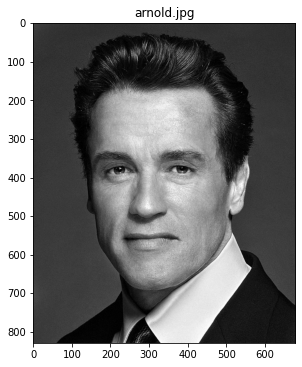

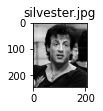

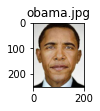

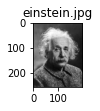

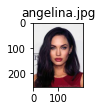

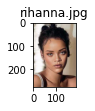

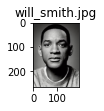

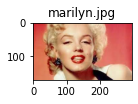

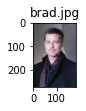

In [34]:
# Graficamos algunas imágenes
k = 1
plt.figure(figsize=(20,20))

for image in lista_imagenes:

  # esta línea se agrega porque dentro de cada directorio google colab guarda
  # una copia de este jupyter notebook .ipynb_checkpoints
  if image[-1] == 'g':
    img = plt.imread(path + image)
    plt.subplot(3, 3,k)
    plt.imshow(img)
    plt.title(image)
    plt.show()
    k += 1

Como se puede observar, las dimensiones de las imágenes son diferentes. Ésto implica mayores recursos de GPU y tiempo, al momento de entrenar una IA con una masa importante de imágenes. Lo que se hace habitualmente es reducir las dimensiones de las imágenes, dejándolas con la misma cantidad de pixeles. El procedimiento se llama redimensionamiento de imágenes, y se realiza con un método que viene incluido en el paquete OpenCV.

## Redimensionar imágenes
Vamos a reducir el tamaño de la imagen con un método de interpolación, usando el paquete OpenCV. Dejaremos las imágenes de $100\times100$ pixeles.
Para más detalles ver https://docs.opencv.org/4.1.2/da/d6e/tutorial_py_geometric_transformations.html

In [35]:
from pathlib import Path

In [36]:
# primero creamos un nuevo directorio y la ruta para enviar las imágenes redimensionadas
base_dir = '/content/drive/MyDrive/imagenes/imagenes_redim'
dir_base = Path(base_dir)

if dir_base.exists():
  print('Este Directorio ya existe')
else:
  os.mkdir(dir_base)

In [37]:
# Redimensionamos las imágenes y las enviamos al directorio imagenes_redim

for image in imagens.image_id:

  # relaciona directorio de origen con imagen
  fuente = os.path.join(path, image)

  # este es el directorio destino 
  destino = os.path.join(dir_base, image)

  # carga imagen desde la fuente
  im = cv2.imread(fuente)

  # redimensiona imagen
  im_redim = cv2.resize(im, (100,100), interpolation = cv2.INTER_AREA)

  # guarda imagen redimensionada en directorio destino
  cv2.imwrite(destino, im_redim)

In [38]:
# ciclo para crear DF con metadatos de imagenes redimensionadas
imagens_redim = pd.DataFrame(columns = ['image_id', 'pix_max', 
                                  'pix_min', 'altura', 'ancho', 'canales', 
                                  'tamano'])

# ciclo for para recorrer la lista de imagenes
for foto in lista_imagenes:

  # esta línea se agrega porque dentro de cada directorio google colab guarda
  # una copia de este jupyter notebook .ipynb_checkpoints
  if foto[-1] == 'g':
    # crea  el camino para llegar a la imagen
    # path fue creado en una de las líneas arriba
    camino_foto_redim = '/content/drive/MyDrive/imagenes/imagenes_redim/' + foto

    # carga la imagen
    foto_redim = cv2.imread(camino_foto_redim)
    pix_max, pix_min, alto, ancho, canales, tamano = metadatos(foto_redim)

    # llenado del dataframe
    imagens_redim = imagens_redim.append({'image_id':foto, 'pix_max':pix_max,
                             'pix_min': pix_min, 'altura':alto, 
                              'ancho':ancho, 'canales':canales, 
                              'tamano':tamano}, ignore_index = True)

In [39]:
imagens_redim.head()

,image_id,pix_max,pix_min,altura,ancho,canales,tamano
0,arnold.jpg,252,0,100,100,3,30000
1,silvester.jpg,248,0,100,100,3,30000
2,obama.jpg,253,0,100,100,3,30000
3,einstein.jpg,255,3,100,100,3,30000
4,angelina.jpg,255,0,100,100,3,30000


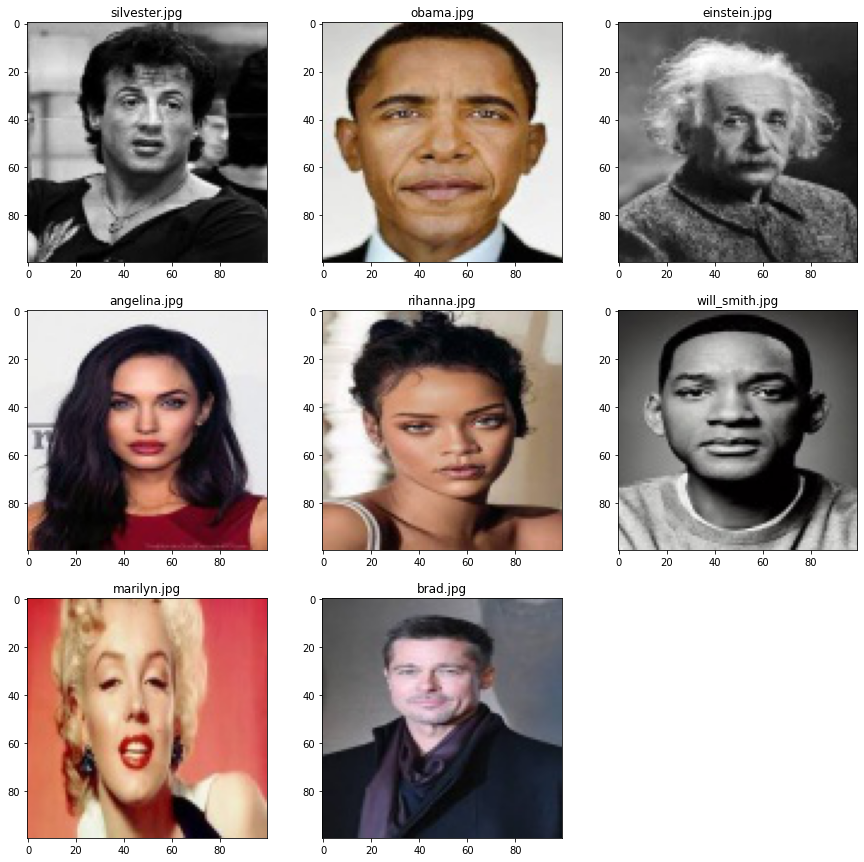

In [40]:
# graficamos las imágenes redimensinadas
ruta = path + 'imagenes_redim/'
plt.figure(figsize=(15,15))
k=1
for image in lista_imagenes[1:]:

  if image[-1] == 'g':
    img = plt.imread(ruta + image)

    plt.subplot(3,3,k)
    plt.imshow(img)
    plt.title(image)
    k += 1

## Augmentation o Creación de imágenes sintéticas
Para entrenar una Inteligencia Artificial se requiere una cantidad importante de datos. Sin embargo, muchas veces no es posible tener esa masa necesaria de datos para el entrenamiento de la IA. En ese caso, se recurre a la creación de datos sintéticos a partir de los datos disponibles. 
Las imágenes sintéticas son copias de las originales que están ligeramente giradas, trasladadas o invertidas. 

In [51]:
# Las imágenes están en imagenes_redim. Creamos un directorio dentro de este directorio
# Y lo llamamos sintenticas.
salida = '/content/drive/MyDrive/imagenes/imagenes_redim/'
llegada = '/content/drive/MyDrive/imagenes/imagenes_redim/sinteticas2'
# Crea el directorio sinteticas
os.mkdir(llegada)

In [42]:
IMAGE_HEIGHT, IMAGE_WIDTH = (100, 100)
NUM_IMAGENS_SINTETICAS = 30

In [54]:
# Crea imágenes sintéticas

# loop por la lista de imágenes que tenemos a disposición en el directorio 'salida'
# copiamos las imágenes al directorio 'llegada'
for m in os.listdir(salida):
  if m[-1] == 'g':
    source = os.path.join(salida, m)
    destino = os.path.join(llegada, m)
    shutil.copyfile(source, destino)

path = salida
save_path = llegada

# creamos el objeto que generará las imágenes sintéticas
# vamos a pemitir que eel objeto cree imágenes sintéticas rotándolas 25°
datagen = ImageDataGenerator(rotation_range = 50,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             zoom_range = 0.1,
                             horizontal_flip = True,
                             fill_mode = 'nearest')

# Tamaño del batch

batch_size = 2

# Generación de los datos
aug_datagen = datagen.flow_from_directory(path,
                                          save_to_dir = save_path,
                                          save_format = 'png',
                                          target_size = (IMAGE_HEIGHT, IMAGE_WIDTH),
                                          batch_size = batch_size)





# generamos las imágenes augmentadas
num_files = len(os.listdir(salida))

# Creamos una cantidad semejande de imágenes aumentadas para cada imágen original
num_batches = int(np.ceil((NUM_IMAGENS_SINTETICAS - num_files) / batch_size))

for i in range(0, num_batches):
        imgs, labels = next(aug_datagen)
        

Found 36 images belonging to 2 classes.


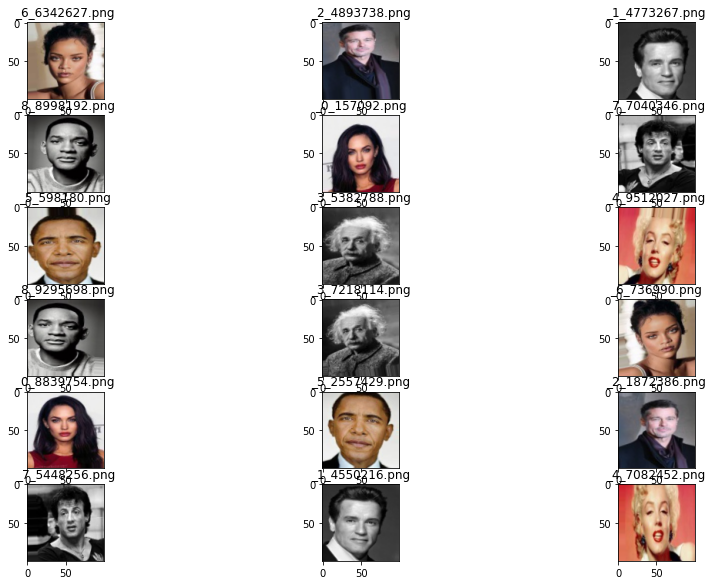

In [50]:
# graficamos imagenes sintéticas con rango de rotación 10
ruta_sint = '/content/drive/MyDrive/imagenes/imagenes_redim/sinteticas/'
plt.figure(figsize=(15,15))
k = 1

for image in os.listdir(ruta_sint):
  if image[-3:] == 'png':
    img = plt.imread(ruta_sint + image)
    plt.subplot(9,3,k)
    plt.imshow(img)
    plt.title(image)
    k += 1

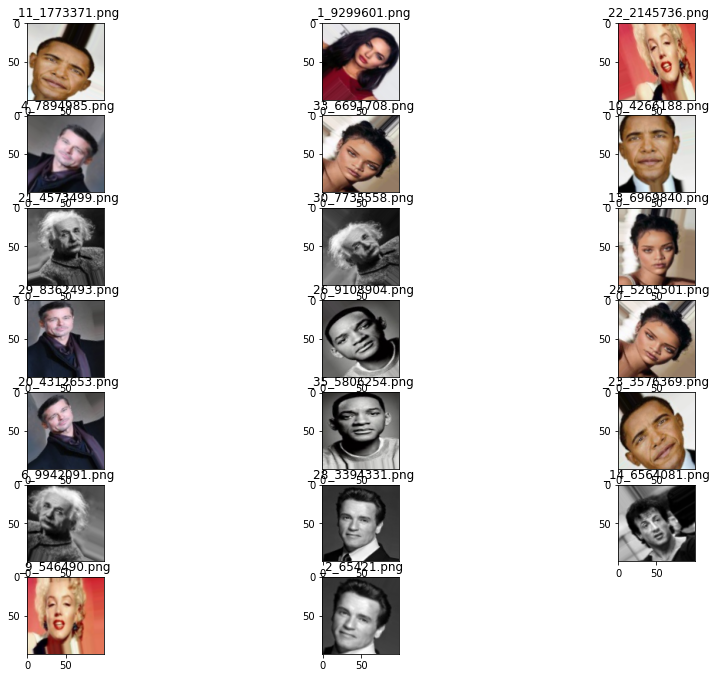

In [55]:
# graficamos imagenes sintéticas con rango de rotación 50
ruta_sint = '/content/drive/MyDrive/imagenes/imagenes_redim/sinteticas2/'
plt.figure(figsize=(15,15))
k = 1

for image in os.listdir(ruta_sint):
  if image[-3:] == 'png':
    img = plt.imread(ruta_sint + image)
    plt.subplot(9,3,k)
    plt.imshow(img)
    plt.title(image)
    k += 1